# <center>OpenCV做Hough变换</center>

By [青衣极客 Blue Geek](https://mp.weixin.qq.com/s/nPSNJG8lntk4Fs2BqlLQyg)

In 2020-01-22

随着深度学习的流行，Hough变换似乎已经成为了一个古老的几何形状检测方法。不过对于一些嵌入式应用而言，使用这种方法仍然是一种很不错的选择。还记得以前做工件尺寸测量、车道线检测或者球类目标定位的时候都是使用Hough变换完成的。相比较与深度学习模型回归参数，Hough变换求解参数的方法更具解释性。理解这种朴素的参数求解方案或许会对开发出新的参数求解算法提供基础。

## 1. Hough直线变换

Hough变换的基本思想一言以蔽之就是：使用轮廓点的位置在参数空间进行投票。比如一个直线的方程可以表述为：y = mx + c，其中的m和c就是参数，其取值的可能性就构成了一个二维的参数空间。xy坐标系中的任何一条直线都对应这参数空间中的一个点，所以只需确定mc参数空间中的一个点即可求解出xy空间的一条直线。由于mc参数形式的表示不便于转换成参数空间的直线方程，以上xy坐标系下的直线方程还可以转换为$\rho-\theta$参数坐标系下的方程：$\rho = x\cos(\theta) + y \sin(\theta)$, 其中$\rho$表示直线到原点的距离，$\theta$表示原点到直线的垂线与x轴所成的角度。从$\rho-\theta$参数空间的直线方程可知，xy坐标系的一个点决定了$\rho-\theta$参数坐标系下的一条直线。假设xy坐标系下有1000个点，那就可以在$\rho-\theta$参数坐标系下作出1000条直线。这些参数空间的直线会存在相交的情况，从那些相交点中挑选出投票率比较高的点就对应这xy坐标系下的直线，也就是我们需要求解的直线。

对于一张普通的RGB图，需要求解其中直线的方程则需以下步骤：(1)将RGB图转换成灰度图，(2)从灰度图产生边缘图，(3)使用边缘图上的轮廓点在$\rho-\theta$参数空间进行投票。下面的例程就是演示从一个RGB图中找出直线。在Hough变换获得直线方程的参数之后，将参数带入方程就可以获得xy坐标系下的直线方程。要在图像中明确绘制出直线的位置，只需取x=0和x=width这两个特殊点即可。

<IPython.core.display.Javascript object>


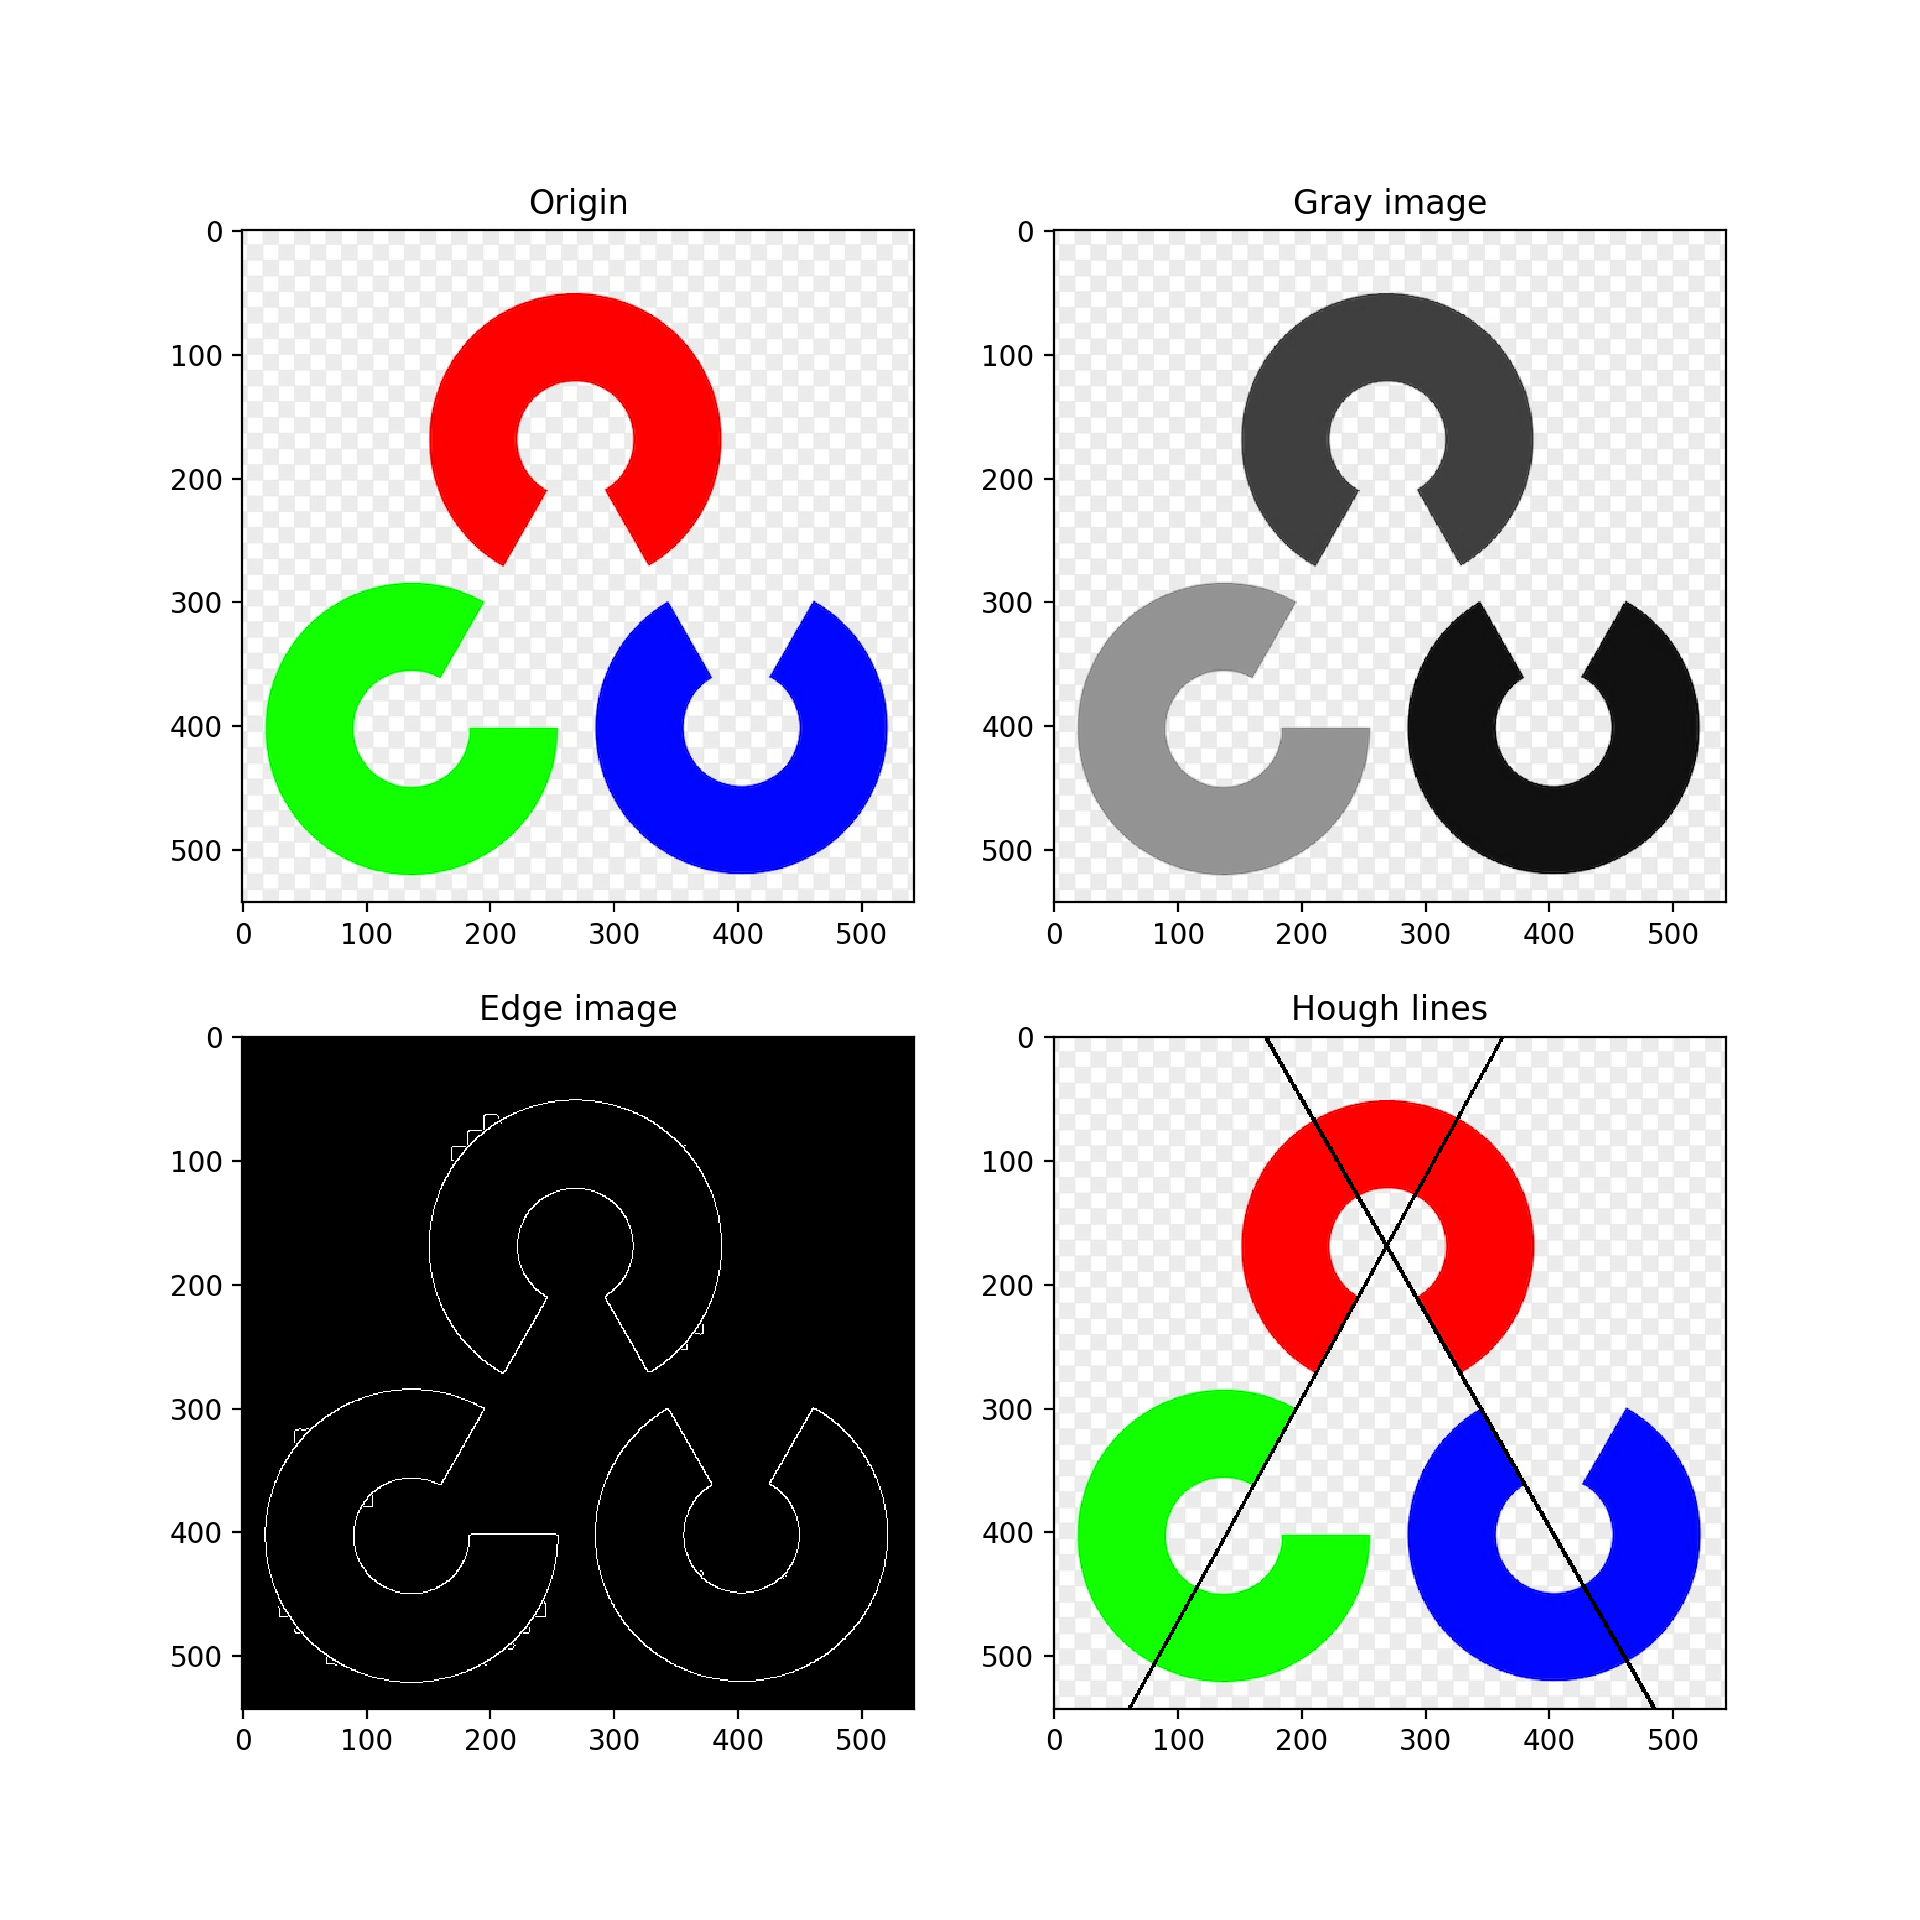

In [1]:
import cv2
import matplotlib 
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
# 显示原图
plt.figure(figsize=(9.6, 9.6))
plt.subplot(2,2,1)
img = cv2.imread('../data/bg66/opencv-icon.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Origin')
# 显示灰度图
plt.subplot(2,2,2)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray image')
# 显示边缘图
plt.subplot(2,2,3)
# 计算边缘图
edge = cv2.Canny(gray_img, threshold1=50, threshold2=150, apertureSize=3) 
plt.imshow(edge, cmap='gray')
plt.title('Edge image')
# 显示结果直线图
plt.subplot(2,2,4)
# hough变换检测直线
lines = cv2.HoughLines(edge, rho=1, theta=np.pi/180, threshold=100)
# 绘制直线
paint_img = img.copy()
for row in range(lines.shape[0]):
    params = lines[row][0]
    rho, theta = params[0], params[1]
    # rho = x\cos(\theta) + y\sin(\theta)
    a, b = np.cos(theta), np.sin(theta)
    x1 = 0
    y1 = int(rho / b)
    x2 = paint_img.shape[1]
    y2 = int((rho - x2*a) / b)
    # draw line
    cv2.line(paint_img, (x1,y1), (x2,y2), (0,0,0), 2)
plt.imshow(cv2.cvtColor(paint_img, cv2.COLOR_BGR2RGB))
plt.title('Hough lines')
plt.savefig('../output/bg67/lines.png', dpi=300, bbox_inches='tight')

从例程可以看出边缘检测Canny算子和Hough直线变换函数都有很多参数需要调整。其中Canny算子的threshold1和threshold2是一组迟滞的阈值，apertureSize是Canny算子调用Sobel算子时的参数。对于HoughLines()函数中最重要的参数就是threshold，该参数为投票数量阈值，即超过该阈值的投票才是有效的参数解。

直接使用这种标准的Hough变换需要在一个二维空间内进行那么多点的投票，其实还是很耗费时间的。如果能够从边缘图中采样一些点进行投票就能提高不少效率，但是代价就是可能存在漏检，这种情况对应的投票数量阈值也许调小。OpenCV提供了cv2.HoughLinesP()函数完成这种概率Hough直线变换，大家可以通过手册进一步详细了解。

## 2. Hough圆形变换

圆形的方程可以表示为：$(x-x0)^2+(y-y0)^2=r^2$，其中$(x0, y0)$为圆心，$r$为半径。从方程可以看出圆形的Hough变换需要在一个3维的参数空间进行投票。可想而知，这种计算压力是难以接受的，因此必须考虑使用一些手段。OpenCV的cv2.HoughCircles()函数目前只提供了一种实现方法，即cv2.HOUGH_GRADIENT，Hough梯度法，使用边缘的梯度信息来求解参数。其中的param1和param2是求解器在调用Canny算子进行边缘检测时用到的参数。由于在函数内部进行边缘即梯度的计算，因此传入函数的图像需要是灰度图，这在手册中已经明确说明。以下例程演示了使用OpenCV提供的接口完成Hough圆形变换。

<IPython.core.display.Javascript object>


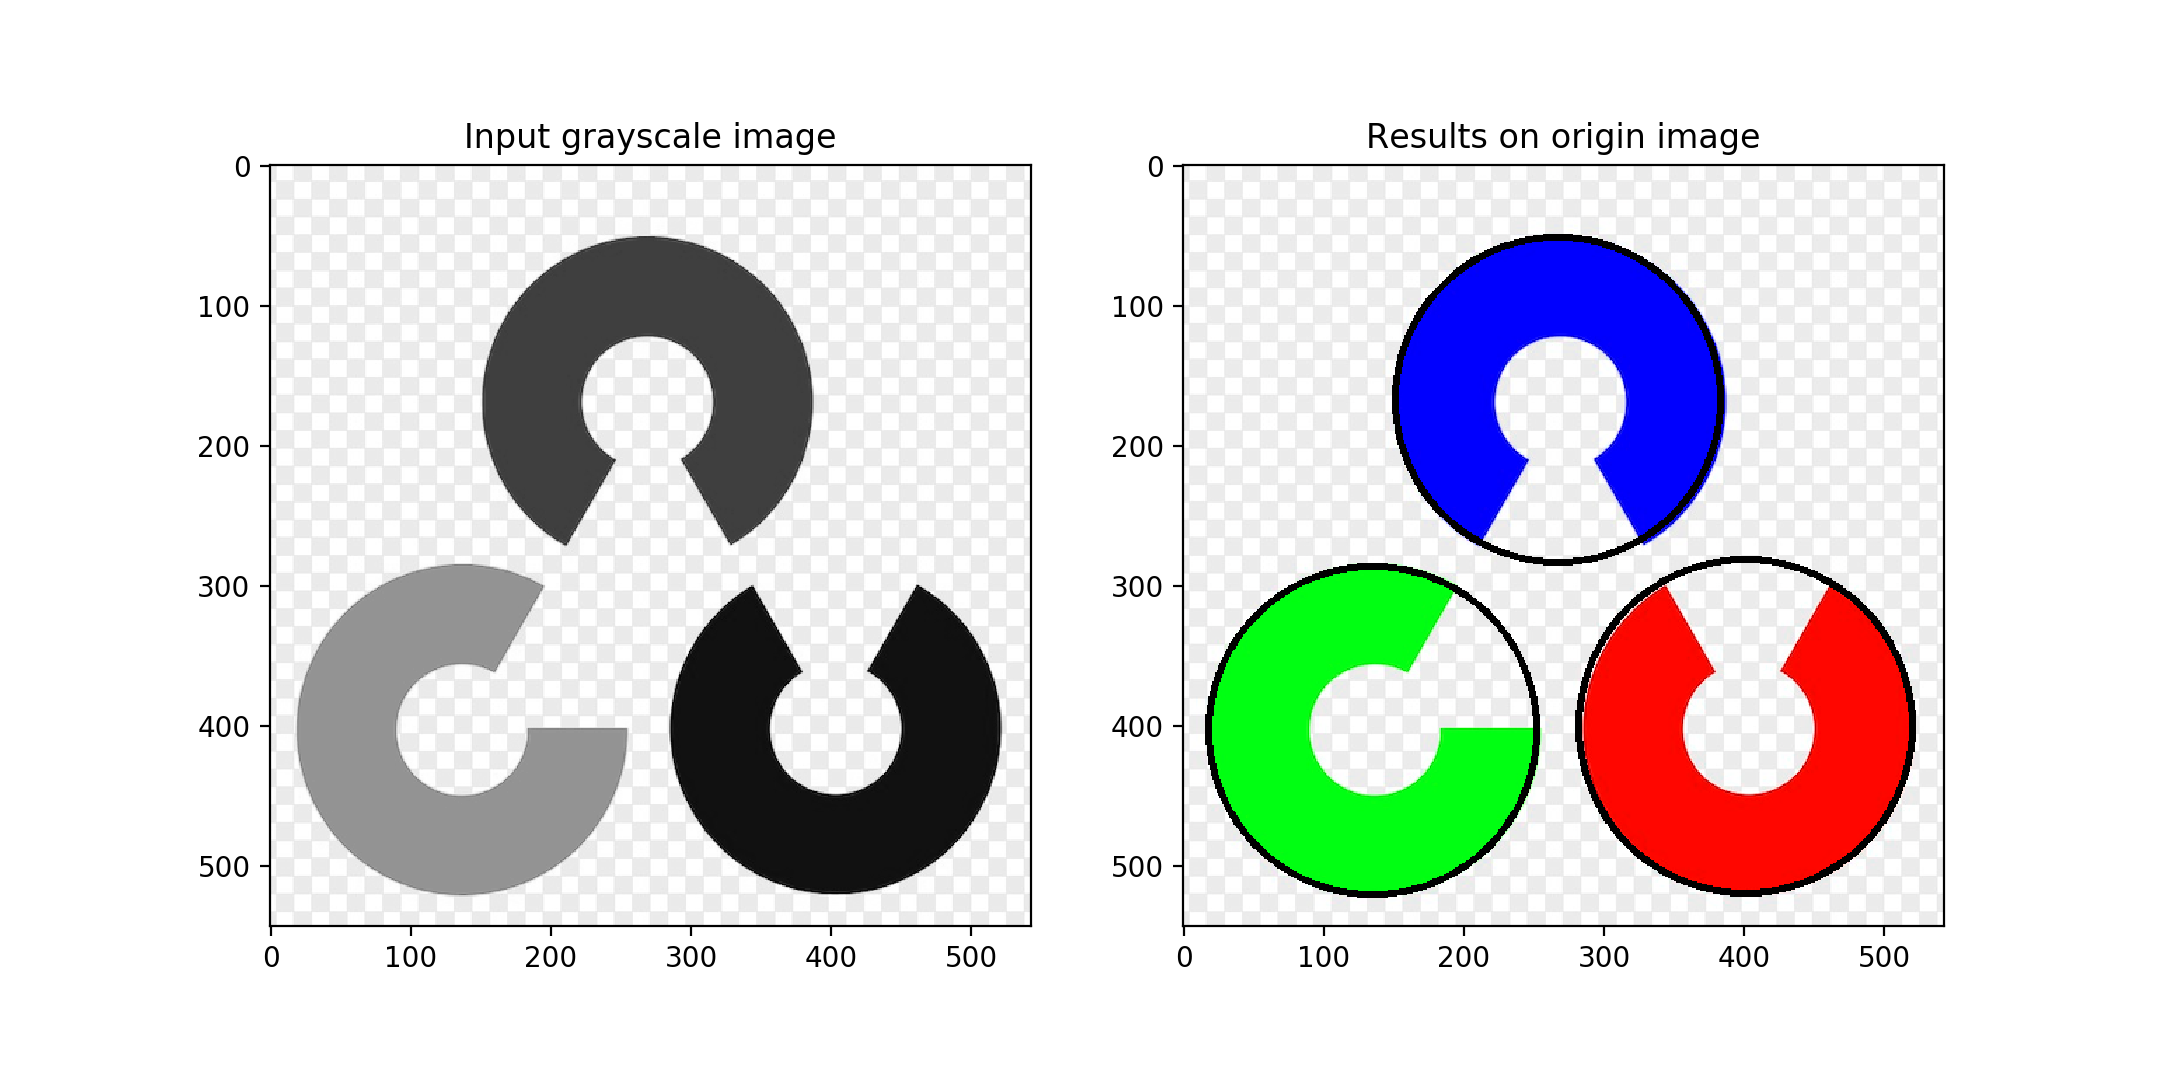

In [2]:
circles = cv2.HoughCircles(
    gray_img, method=cv2.HOUGH_GRADIENT, dp=1, minDist=20,
    param1=200, param2=50, minRadius=0, maxRadius=0)
# 显示输入图像
plt.figure(figsize=(10.8, 5.4))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Input grayscale image')
# 显示结果图
plt.subplot(1,2,2)
paint_img = img.copy()
for row in range(circles[0].shape[0]):
    params = np.int32(circles[0][row])
    x, y, r = params[0], params[1], params[2]
    cv2.circle(paint_img, (x, y), r, (0,0,0), 3)
plt.imshow(paint_img)
plt.title('Results on origin image')
plt.savefig('../output/bg67/circles.png', dpi=300, bbox_inches='tight')

从求解结果来看，该方法能够将准确得将图像中的三个大圆检测出来，但是小圆就漏掉了，这需要仔细调整相关的参数才能检测得到。

Hough变换求解参数一般不适用于参数过多的情况，因为3个参数就已经让算力捉襟见肘了，最好还是只有两个参数的情况。Hough方式求解直线或者圆形还有一个好处是不需要标注。因此在标注数据缺乏的情况下，可以先使用Hough变换程程一批粗陋的标注，然后人工筛选提供标注的质量，等数据充足时在使用深度学习进一步提升效果。